# Homework 2 - Deep Learning

Artificial Intelligence and Machine Learning  
Loparco Enrico - s261072

## Table of Contents
* [1. Data Preparation](#data-preparation)
* [2. Training From Scratch](#training)
* [3. Transfer Learning](#transfer-learning)
    + [3.1 Finetuning](#finetuning)
    + [3.2 "Freeze" layers](#freezing)
        + [3.2.1 Train fully connected layers](#fully-connected)
        + [3.2.2 Train convolutional layers](#convolutional)
* [4. Data Augmentation](#data-augmentation)
* [5. Beyond AlexNet](#beyond-alexnet)



**Install requirements**

In [1]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.4.2'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
!pip3 install 'torchsummary'

**Import libraries**

In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, Dataset
from torch.backends import cudnn
import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.models import vgg16

from sklearn.model_selection import train_test_split
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import time
import copy

# Set seed to get reproducible results
SEED = 42 
torch.manual_seed(SEED)

**Set default arguments**

In [0]:
# Starting hyperparameters, changed through the homework

DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

## 1.Data Preparation <a name="data-preparation"></a>

**Load dataset from GitHub**

In [0]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [5]:
# Clone github repository with data
if not os.path.isdir('./Homework2-Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

MAIN_DIR = 'Homework2-Caltech101'
DATA_DIR = 'Homework2-Caltech101/101_ObjectCategories'

# Upload train+validation set
labels = {}
X = []
y = []
filename = MAIN_DIR + '/train.txt'
with open(filename, 'r') as f:
  for line in f.read().splitlines():
    # Do not include background images
    if 'BACKGROUND' not in line:    
      # Add label to dictionary if not already present
      label = line.split('/')[0]
      if label not in labels:
        labels[label] = len(labels)

      # Add current sample to train set
      img = pil_loader(DATA_DIR + '/' + line)
      X.append(img)
      y.append(labels[label])

# Upload test set
X_test = []
y_test = []
filename = MAIN_DIR + '/test.txt'
with open(filename, 'r') as f:
  for line in f.read().splitlines():
    # Do not include background images
    if 'BACKGROUND' not in line:    
      label = line.split('/')[0]

      # Add current sample to test set
      img = pil_loader(DATA_DIR + '/' + line)
      X_test.append(img)
      y_test.append(labels[label]) 

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9256, done.
remote: Total 9256 (delta 0), reused 0 (delta 0), pack-reused 9256
Receiving objects: 100% (9256/9256), 129.48 MiB | 21.04 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (9149/9149), done.


**Split train and validation set**

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, stratify=y, random_state=SEED)

train_dataset_size = len(X_train)
val_dataset_size = len(X_val)
test_dataset_size = len(X_test)
print(f"Train dataset: {train_dataset_size}")
print(f"Validation dataset: {val_dataset_size}")
print(f"Test dataset: {test_dataset_size}\n")

# Print the number of samples for train and validation set for the first 10 labes
# (to check the result of the previous operation)
for val in list(labels.values())[:10]:
  print(f"Label {val}: {y_train.count(val)} samples in train, {y_val.count(val)} samples in validation")

Train dataset: 2892
Validation dataset: 2892
Test dataset: 2893

Label 0: 18 samples in train, 18 samples in validation
Label 1: 267 samples in train, 267 samples in validation
Label 2: 14 samples in train, 14 samples in validation
Label 3: 14 samples in train, 14 samples in validation
Label 4: 15 samples in train, 16 samples in validation
Label 5: 18 samples in train, 18 samples in validation
Label 6: 15 samples in train, 16 samples in validation
Label 7: 11 samples in train, 11 samples in validation
Label 8: 42 samples in train, 43 samples in validation
Label 9: 33 samples in train, 32 samples in validation


**Create custom *Dataset* object**

In [0]:
class Caltech(Dataset):
    labels = {}
    def __init__(self, data, transform=None):
        self.transform = transform

        '''
        - Labels start from 0, so for Caltech you have lables 0...100 (excluding the background class) 
        '''
        self.samples = []
        for image, label in data:
          self.samples.append((image, label))  

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''
        # Access image and label via index: image is PIL Image, label is int
        image, label = self.samples[index]

        # Apply preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        '''
        return len(self.samples)

**Show images in dataset**

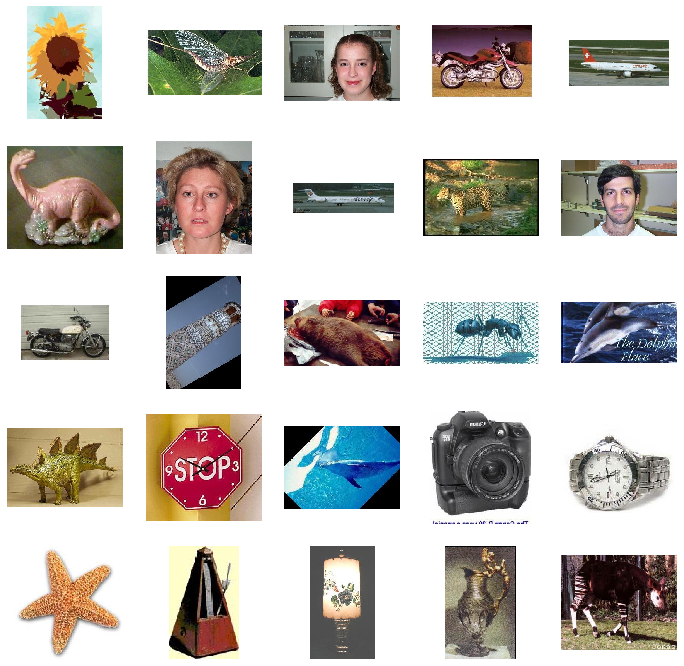

In [8]:
# Plot a few images from dataset
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
for i in range(5):
    for j in range(5):
        img = X_train[i*5+j]
        ax[i, j].imshow(img)
        ax[i, j].axis('off')

# 2. Train From Scratch <a name="training"></a>

**Define transformations (data preprocessing)**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Load data**

In [10]:
# Prepare Pytorch train/test Datasets
train_dataset = Caltech(zip(X_train, y_train), transform=train_transform)
validation_dataset = Caltech(zip(X_val, y_val), transform=train_transform)
test_dataset = Caltech(zip(X_test, y_test), transform=eval_transform)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Validation Dataset: {}'.format(len(validation_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Validation Dataset: 2892
Test Dataset: 2893


**Show images after transformation**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

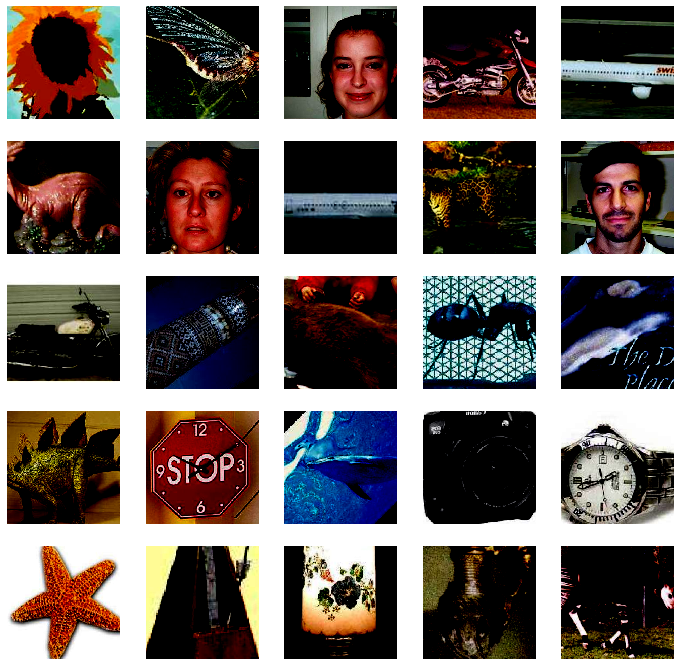

In [11]:
# Plot a few images after transformation
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
for i in range(5):
    for j in range(5):
        img = train_dataset[i*5+j][0]
        # Permute: from (C, H, W) to (H, W, C) to allow visualization
        img = img.permute(1, 2, 0)
        ax[i, j].imshow(img)
        ax[i, j].axis('off')

**Display AlexNet architecture**

In [12]:
summary(alexnet().to(DEVICE), (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

**Define parameters for tuning**

In [0]:
# Different parameter were tested, here the final ones
lr = 1e-2
step_size = 20
momentum = MOMENTUM
batch_size = BATCH_SIZE

**Prepare dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

**Prepare network**

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(net.classifier[6].in_features, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs

**Prepare training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=momentum, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=GAMMA)

**Define functions for train, evaluation and plots**

In [0]:
def train_one_epoch(net, optimizer, dataloader, dataset_size, device, losses, accuracies):
    net.train() # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over the dataset
    for images, labels in dataloader:
        # Bring data over the device of choice
        images = images.to(device)
        labels = labels.to(device)

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients


        with torch.set_grad_enabled(True):
            # Forward pass to the network
            outputs = net(images)
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            # Compute loss based on output and ground truth
            loss = criterion(outputs, labels)

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients
            
        # statistics
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Calculate Loss and Accuracy
    epoch_loss = running_loss / float(dataset_size)
    epoch_acc = running_corrects.double() / float(dataset_size)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc.item())
    print('train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [0]:
def evaluate(model, dataloader, dataset_size, device, losses, accuracies, best_acc, best_model_wts):
    net.eval() # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over the dataset
    for images, labels in dataloader:
        # Bring data over the device of choice
        images = images.to(device)
        labels = labels.to(device)

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # disable gradient to save resources (no need to calculate gradient in test phase)
        with torch.set_grad_enabled(False):
            # Forward pass to the network
            outputs = net(images)
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            # Compute loss based on output and ground truth
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Calculate Loss and Accuracy
    epoch_loss = running_loss / float(dataset_size)
    epoch_acc = running_corrects.double() / float(dataset_size)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc.item())
    print('val Loss: {:.4f} Acc: {:.4f}\n'.format(epoch_loss, epoch_acc))

    # deep copy the model (if the best so far)
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(net.state_dict())
    return best_acc, best_model_wts


In [0]:
def plot_accuracy_and_loss(accuracies, losses, epochs, title):
    fig, ax = plt.subplots(1, 2, figsize=(22, 5))
    epochs = np.arange(1, epochs+1)

    ax[0].plot(epochs, accuracies['train'], label='train')
    ax[0].plot(epochs, accuracies['val'], label='val')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xticks(epochs)
    ax[0].legend()

    ax[1].plot(epochs, losses['train'], label='train')
    ax[1].plot(epochs, losses['val'], label='val')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_xticks(epochs)
    ax[1].legend()
    fig.suptitle(title, fontsize=14)

**Train ('babysitting' strategy, trial and error)**

In [0]:
def train(net, scheduler, optimizer, train_dataloader, validation_dataloader, train_dataset_size, val_dataset_size, criterion, epochs, device):
    net = net.to(device)    # This will bring the network to GPU if device is cuda
                            # By default, everything is loaded to cpu
    cudnn.benchmark # Calling this optimizes runtime
    
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0

    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}

    for epoch in range(epochs):
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, epochs, scheduler.get_lr()))

        # Train for one epoch
        train_one_epoch(net, optimizer, train_dataloader, train_dataset_size, device, losses['train'], accuracies['train'])
        # Update the learning rate (learning rate dacay)
        scheduler.step()
        # Evaluate on the test dataset
        best_acc, best_model_wts = evaluate(net, validation_dataloader, test_dataset_size, device, losses['val'], accuracies['val'], best_acc, best_model_wts)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights and plot
    net.load_state_dict(best_model_wts)# Prepare Pytorch train/test Datasets
    plot_accuracy_and_loss(accuracies, losses, epochs, "learning rate=" + str(lr) + " step size=" + str(step_size) + " batch size=" + str(batch_size))
    return net

Starting epoch 1/30, LR = [0.01]
train Loss: 4.4876 Acc: 0.0705
val Loss: 4.4773 Acc: 0.0895

Starting epoch 2/30, LR = [0.01]
train Loss: 4.4678 Acc: 0.0896
val Loss: 4.4514 Acc: 0.0892

Starting epoch 3/30, LR = [0.01]
train Loss: 4.4359 Acc: 0.0892
val Loss: 4.4103 Acc: 0.0899

Starting epoch 4/30, LR = [0.01]
train Loss: 4.3418 Acc: 0.0902
val Loss: 4.1499 Acc: 0.0902

Starting epoch 5/30, LR = [0.01]
train Loss: 4.1574 Acc: 0.0909
val Loss: 4.0960 Acc: 0.0902

Starting epoch 6/30, LR = [0.01]
train Loss: 4.1108 Acc: 0.0892
val Loss: 4.0665 Acc: 0.0902

Starting epoch 7/30, LR = [0.01]
train Loss: 4.0802 Acc: 0.1138
val Loss: 4.0550 Acc: 0.1524

Starting epoch 8/30, LR = [0.01]
train Loss: 4.0573 Acc: 0.1276
val Loss: 4.0525 Acc: 0.1479

Starting epoch 9/30, LR = [0.01]
train Loss: 4.0247 Acc: 0.1234
val Loss: 3.9686 Acc: 0.1272

Starting epoch 10/30, LR = [0.01]
train Loss: 3.9699 Acc: 0.1266
val Loss: 3.8733 Acc: 0.1511

Starting epoch 11/30, LR = [0.01]
train Loss: 3.8980 Acc: 0

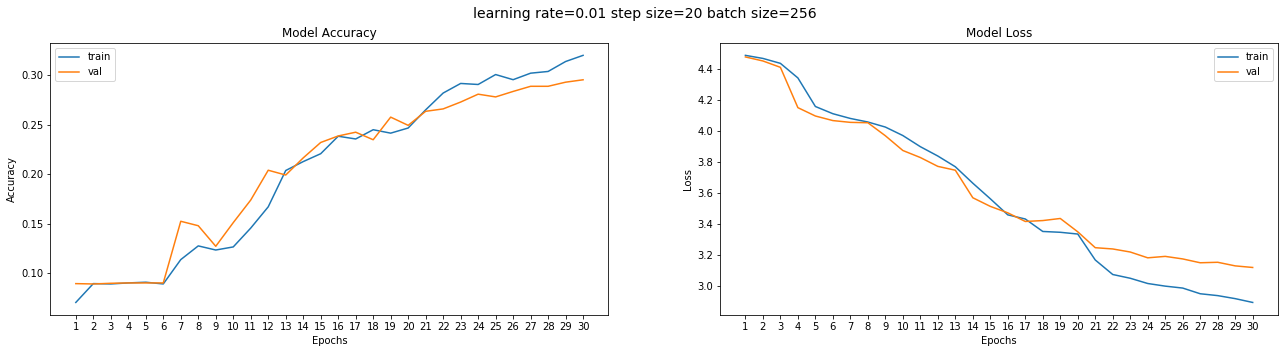

In [46]:
net = train(net, scheduler, optimizer, train_dataloader, validation_dataloader, train_dataset_size, val_dataset_size, criterion, NUM_EPOCHS, DEVICE)

**Random search**

In [0]:
num_iterations = 8

for i in range(num_iterations):
    rand = -2 * np.random.rand() # r in [-2,0]
    lr = 10**rand # 10^(-2) ... 10^0
    rand = -2 * np.random.rand() - 1 # r in [-3,-1]
    momentum = 1 - 10**rand # 0.9 ... 0.999
    print(f"Learning rate:{lr} Momentum:{momentum}")
    print('-' * 60 + '\n');

    net = alexnet()
    net.classifier[6] = nn.Linear(net.classifier[6].in_features, NUM_CLASSES)
    parameters_to_optimize = net.parameters()
    optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=momentum, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    net = net.to(DEVICE)

    since = time.time()
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    
    for epoch in range(NUM_EPOCHS):
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

        # Train for one epoch
        train_one_epoch(net, optimizer, train_dataloader, len(train_dataset), DEVICE, losses['train'], accuracies['train'])
        # Update the learning rate (learning rate dacay)
        scheduler.step()
        # Evaluate on the test dataset
        best_acc, best_model_wts = evaluate(net, validation_dataloader, len(validation_dataset), DEVICE, losses['val'], accuracies['val'], best_acc, best_model_wts)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))

    plot_accuracy_and_loss(accuracies, losses, NUM_EPOCHS, "learning rate = " + str(lr)+ "\nmomentum = " + str(momentum))

# load best model weights
net.load_state_dict(best_model_wts)

**Grid search**

In [0]:
for lr in [1e-4, 1e-3, 1e-2, 1e-1, 1]:
    for momentum in [0.9, 0.99, 0.999]:
        print(f"Learning rate:{lr} Momentum:{momentum}")
        print('-' * 60 + '\n');

        net = alexnet()
        net.classifier[6] = nn.Linear(net.classifier[6].in_features, NUM_CLASSES)
        parameters_to_optimize = net.parameters()
        optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=momentum, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
        net = net.to(DEVICE)

        since = time.time()
        losses = {'train': [], 'val': []}
        accuracies = {'train': [], 'val': []}
    
        for epoch in range(NUM_EPOCHS):
            print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

            # Train for one epoch
            train_one_epoch(net, optimizer, train_dataloader, len(train_dataset), DEVICE, losses['train'], accuracies['train'])
            # Update the learning rate (learning rate dacay)
            scheduler.step()
            # Evaluate on the test dataset
            best_acc, best_model_wts = evaluate(net, validation_dataloader, len(validation_dataset), DEVICE, losses['val'], accuracies['val'], best_acc, best_model_wts)

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}\n'.format(best_acc))

        plot_accuracy_and_loss(accuracies, losses, NUM_EPOCHS, "learning rate = " + str(lr)+ "\nmomentum = " + str(momentum))

# load best model weights
net.load_state_dict(best_model_wts)

**Test**

In [0]:
def test(net, dataloader, device):
    # net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        # size = 256*101, the 101 outputs for each batch
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataset))
    print('Test Accuracy: {}'.format(accuracy))

In [48]:
test(net, test_dataloader, DEVICE)

100%|██████████| 12/12 [00:08<00:00,  1.49it/s]

Test Accuracy: 0.3138610438990667


## 3. Transfer Learning <a name="transfer-learning"></a>

### 3.1 Finetuning <a name="finetuning"></a>

**Change transformation functions**

In [0]:
# Normalize input images using ImageNet's mean and standard deviation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

**Define parameters**

In [0]:
# Sets of hyperparameter used to experiment with
lr = 1e-2
step_size = 20
momentum = 0.9
batch_size = 512
weight_decay = 5e-5

**Prepare datasets and dataloaders**

In [0]:
# Prepare datasets using the transformations of the previuos block
train_dataset_tl = Caltech(zip(X_train, y_train), transform=data_transforms['train'])
validation_dataset_tl = Caltech(zip(X_val, y_val), transform=data_transforms['val'])
test_dataset_tl = Caltech(zip(X_test, y_test), transform=data_transforms['val'])

train_dataloader_tl = DataLoader(train_dataset_tl, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
validation_dataloader_tl = DataLoader(validation_dataset_tl, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
test_dataloader_tl = DataLoader(test_dataset_tl, batch_size=batch_size, shuffle=False, num_workers=4)

**Prepare network**

In [27]:
# Use weights trained on ImageNet dataset
net = alexnet(pretrained=True)

# Usual configuration but using the new parameters
net.classifier[6] = nn.Linear(net.classifier[6].in_features, NUM_CLASSES)
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=GAMMA)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:10<00:00, 23.9MB/s]


**Train and test**

Starting epoch 1/30, LR = [0.01]
train Loss: 3.3361 Acc: 0.1947
val Loss: 2.3962 Acc: 0.3602

Starting epoch 2/30, LR = [0.01]
train Loss: 1.9470 Acc: 0.4547
val Loss: 1.4485 Acc: 0.5399

Starting epoch 3/30, LR = [0.01]
train Loss: 0.9563 Acc: 0.6421
val Loss: 0.8595 Acc: 0.6581

Starting epoch 4/30, LR = [0.01]
train Loss: 0.4615 Acc: 0.7590
val Loss: 0.6998 Acc: 0.6986

Starting epoch 5/30, LR = [0.01]
train Loss: 0.2771 Acc: 0.8036
val Loss: 0.6581 Acc: 0.7072

Starting epoch 6/30, LR = [0.01]
train Loss: 0.1546 Acc: 0.8375
val Loss: 0.6086 Acc: 0.7217

Starting epoch 7/30, LR = [0.01]
train Loss: 0.0793 Acc: 0.8624
val Loss: 0.6540 Acc: 0.7231

Starting epoch 8/30, LR = [0.01]
train Loss: 0.0515 Acc: 0.8672
val Loss: 0.6614 Acc: 0.7307

Starting epoch 9/30, LR = [0.01]
train Loss: 0.0394 Acc: 0.8703
val Loss: 0.6808 Acc: 0.7314

Starting epoch 10/30, LR = [0.01]
train Loss: 0.0181 Acc: 0.8793
val Loss: 0.7076 Acc: 0.7311

Starting epoch 11/30, LR = [0.01]
train Loss: 0.0190 Acc: 0

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.7033 Acc: 0.7401

Training complete in 7m 13s
Best val Acc: 0.746630


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Test Accuracy: 0.8406498444521259


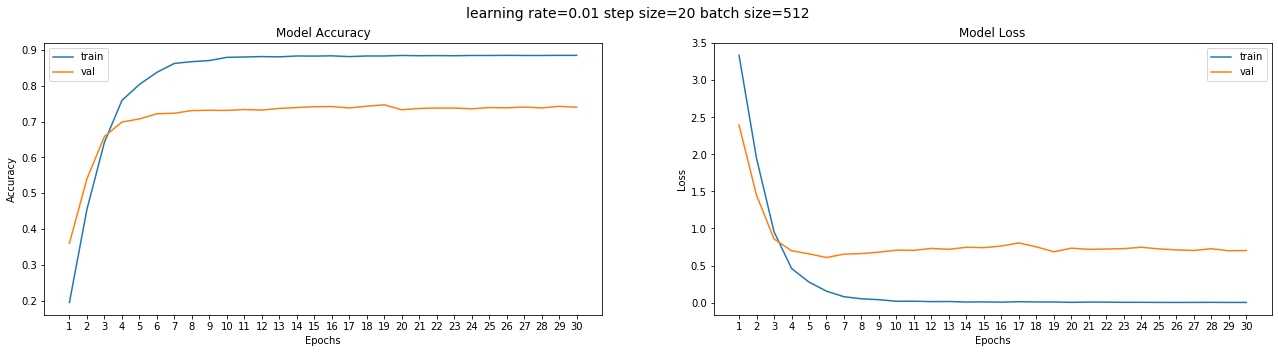

In [28]:
net = train(net, scheduler, optimizer, train_dataloader_tl, validation_dataloader_tl, train_dataset_size, val_dataset_size, criterion, NUM_EPOCHS, DEVICE)
test(net, test_dataloader_tl, DEVICE)

### 3.2 "Freeze" layers <a name="freezing"></a>

**Visualize AlexNet layers**

In [29]:
print(alexnet())

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### 3.2.1 Train only fully connected layers <a name="fully-connected"></a>

**Set layers to optimize**

In [0]:
# Initialize the model
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(net.classifier[6].in_features, NUM_CLASSES)

# set layers to optimize
parameters_to_optimize = net.classifier.parameters()

In [0]:
optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=GAMMA)

**Train and test**

Starting epoch 1/30, LR = [0.01]
train Loss: 3.4200 Acc: 0.1881
val Loss: 2.3053 Acc: 0.3661

Starting epoch 2/30, LR = [0.01]
train Loss: 1.7342 Acc: 0.4900
val Loss: 1.3376 Acc: 0.5703

Starting epoch 3/30, LR = [0.01]
train Loss: 0.9400 Acc: 0.6750
val Loss: 0.9037 Acc: 0.6657

Starting epoch 4/30, LR = [0.01]
train Loss: 0.5145 Acc: 0.7704
val Loss: 0.7074 Acc: 0.7065

Starting epoch 5/30, LR = [0.01]
train Loss: 0.3103 Acc: 0.8095
val Loss: 0.6444 Acc: 0.7131

Starting epoch 6/30, LR = [0.01]
train Loss: 0.2209 Acc: 0.8330
val Loss: 0.5999 Acc: 0.7211

Starting epoch 7/30, LR = [0.01]
train Loss: 0.1517 Acc: 0.8475
val Loss: 0.5805 Acc: 0.7290

Starting epoch 8/30, LR = [0.01]
train Loss: 0.1143 Acc: 0.8579
val Loss: 0.5607 Acc: 0.7363

Starting epoch 9/30, LR = [0.01]
train Loss: 0.0815 Acc: 0.8669
val Loss: 0.5794 Acc: 0.7280

Starting epoch 10/30, LR = [0.01]
train Loss: 0.0677 Acc: 0.8724
val Loss: 0.5672 Acc: 0.7338

Starting epoch 11/30, LR = [0.01]
train Loss: 0.0540 Acc: 0

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.5586 Acc: 0.7349

Training complete in 7m 9s
Best val Acc: 0.740408


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


Test Accuracy: 0.8444521258209471


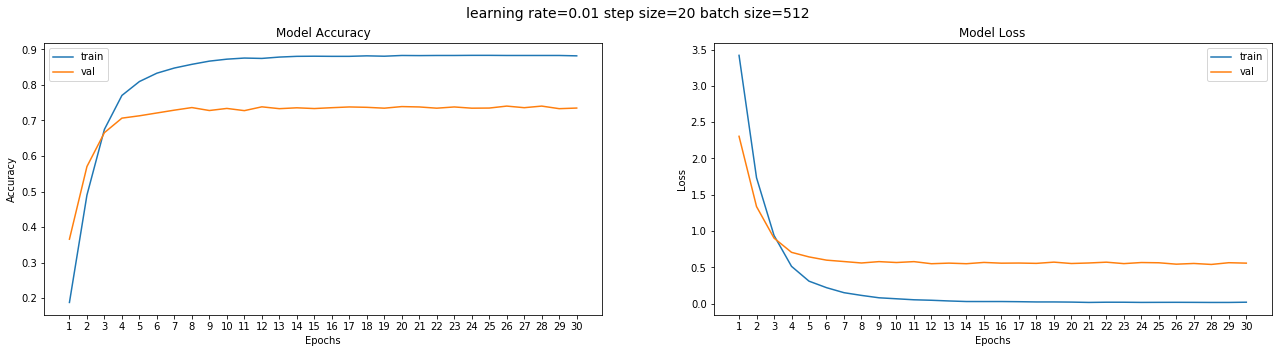

In [32]:
net = train(net, scheduler, optimizer, train_dataloader_tl, validation_dataloader_tl, train_dataset_size, val_dataset_size, criterion, NUM_EPOCHS, DEVICE)
test(net, test_dataloader_tl, DEVICE)

#### 3.2.2 Train only convolutional layers <a name="convolutional"></a>

**Set layers to optimize**

In [0]:
# Initialize the model
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(net.classifier[6].in_features, NUM_CLASSES)

# set layers to optimize
parameters_to_optimize = net.features.parameters()

In [0]:
optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=GAMMA)

**Train and test**

Starting epoch 1/30, LR = [0.01]
train Loss: 4.2166 Acc: 0.0131
val Loss: 4.0182 Acc: 0.0387

Starting epoch 2/30, LR = [0.01]
train Loss: 4.0269 Acc: 0.0467
val Loss: 3.9331 Acc: 0.1179

Starting epoch 3/30, LR = [0.01]
train Loss: 3.9137 Acc: 0.1103
val Loss: 3.7749 Acc: 0.1576

Starting epoch 4/30, LR = [0.01]
train Loss: 3.7232 Acc: 0.1518
val Loss: 3.5479 Acc: 0.1974

Starting epoch 5/30, LR = [0.01]
train Loss: 3.5540 Acc: 0.1926
val Loss: 3.3280 Acc: 0.2205

Starting epoch 6/30, LR = [0.01]
train Loss: 3.3383 Acc: 0.2185
val Loss: 3.1566 Acc: 0.2344

Starting epoch 7/30, LR = [0.01]
train Loss: 3.1397 Acc: 0.2379
val Loss: 3.0302 Acc: 0.2440

Starting epoch 8/30, LR = [0.01]
train Loss: 3.0200 Acc: 0.2462
val Loss: 2.9234 Acc: 0.2496

Starting epoch 9/30, LR = [0.01]
train Loss: 2.9365 Acc: 0.2535
val Loss: 2.8421 Acc: 0.2800

Starting epoch 10/30, LR = [0.01]
train Loss: 2.8370 Acc: 0.2835
val Loss: 2.7653 Acc: 0.2872

Starting epoch 11/30, LR = [0.01]
train Loss: 2.7331 Acc: 0

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 2.2905 Acc: 0.3996

Training complete in 7m 11s
Best val Acc: 0.403387


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


Test Accuracy: 0.4535084687175942


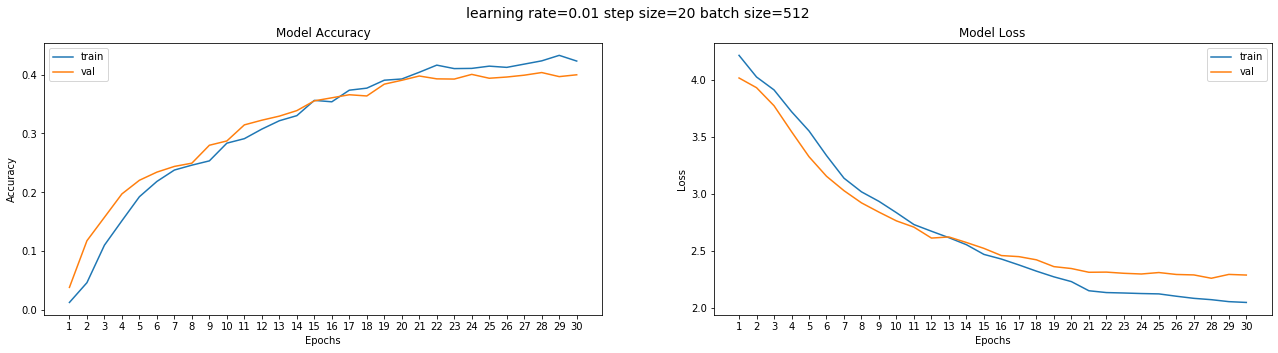

In [35]:
net = train(net, scheduler, optimizer, train_dataloader_tl, validation_dataloader_tl, train_dataset_size, val_dataset_size, criterion, NUM_EPOCHS, DEVICE)
test(net, test_dataloader_tl, DEVICE)

## 4. Data Augmentation <a name="data-augmentation"></a>

**Define transformations**

In [0]:
# The transforms operations are applied to the original images at every batch generation.
# This means that the dataset is left unchanged, only the batch images are copied and transformed at every iteration.

# Data augmentation and normalization for training, just normalization for validation
data_transforms_da = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),      # Crop the given PIL Image to random size and aspect ratio
        transforms.RandomHorizontalFlip(),      # Horizontally flip the given PIL Image randomly with a given probability (dafault 0.5)
        transforms.RandomRotation(degrees=90),  # Rotate the image by angle (-degrees, +degrees)
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

**Load and show data**

In [0]:
train_dataset_da = Caltech(zip(X_train, y_train), transform=data_transforms_da['train'])
validation_dataset_da = Caltech(zip(X_val, y_val), transform=data_transforms_da['val'])
test_dataset_da = Caltech(zip(X_test, y_test), transform=data_transforms_da['val'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

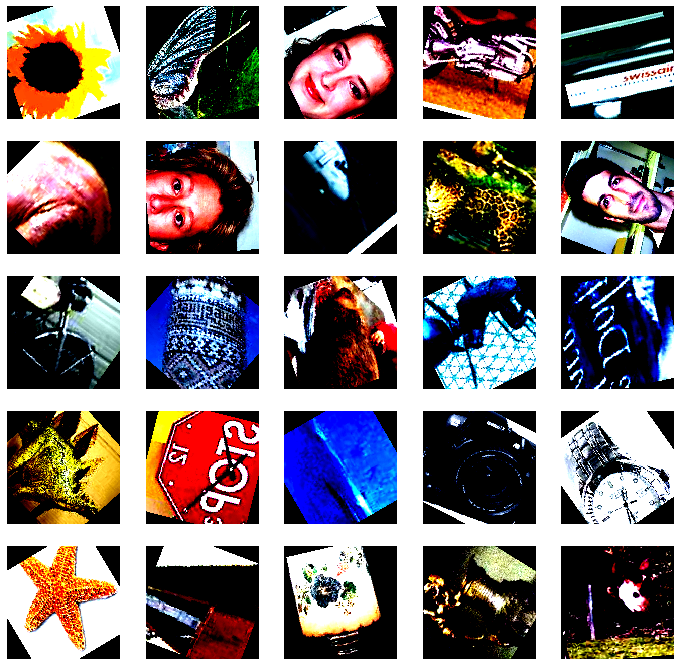

In [0]:
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
for i in range(5):
    for j in range(5):
        img = train_dataset_da[i*5+j][0]
        # permute: from (C, H, W) to (H, W, C) to allow visualization
        img = img.permute(1, 2, 0)
        ax[i, j].imshow(img)
        ax[i, j].axis('off')

**Prepare dataloaders**

In [0]:
train_dataloader_da = DataLoader(train_dataset_da, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
validation_dataloader_da = DataLoader(validation_dataset_da, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
test_dataloader_da = DataLoader(test_dataset_da, batch_size=batch_size, shuffle=False, num_workers=4)

**Prepare network**

In [0]:
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(net.classifier[6].in_features, NUM_CLASSES)
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=GAMMA)

**Train and test**

Starting epoch 1/30, LR = [0.01]
train Loss: 3.7291 Acc: 0.1383
val Loss: 2.9843 Acc: 0.2586

Starting epoch 2/30, LR = [0.01]
train Loss: 2.8277 Acc: 0.2739
val Loss: 2.3730 Acc: 0.3533

Starting epoch 3/30, LR = [0.01]
train Loss: 2.2909 Acc: 0.3655
val Loss: 1.7719 Acc: 0.4767

Starting epoch 4/30, LR = [0.01]
train Loss: 1.8712 Acc: 0.4457
val Loss: 1.4739 Acc: 0.5240

Starting epoch 5/30, LR = [0.01]
train Loss: 1.5639 Acc: 0.4920
val Loss: 1.2751 Acc: 0.5527

Starting epoch 6/30, LR = [0.01]
train Loss: 1.4144 Acc: 0.5266
val Loss: 1.1456 Acc: 0.5838

Starting epoch 7/30, LR = [0.01]
train Loss: 1.3331 Acc: 0.5353
val Loss: 1.0475 Acc: 0.6046

Starting epoch 8/30, LR = [0.01]
train Loss: 1.1414 Acc: 0.5830
val Loss: 1.0845 Acc: 0.6063

Starting epoch 9/30, LR = [0.01]
train Loss: 1.1095 Acc: 0.5927
val Loss: 1.0632 Acc: 0.6094

Starting epoch 10/30, LR = [0.01]
train Loss: 1.0020 Acc: 0.6093
val Loss: 1.0259 Acc: 0.6270

Starting epoch 11/30, LR = [0.01]
train Loss: 0.9533 Acc: 0

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 1.0430 Acc: 0.6505

Training complete in 9m 40s
Best val Acc: 0.650536


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Test Accuracy: 0.7521603871413758


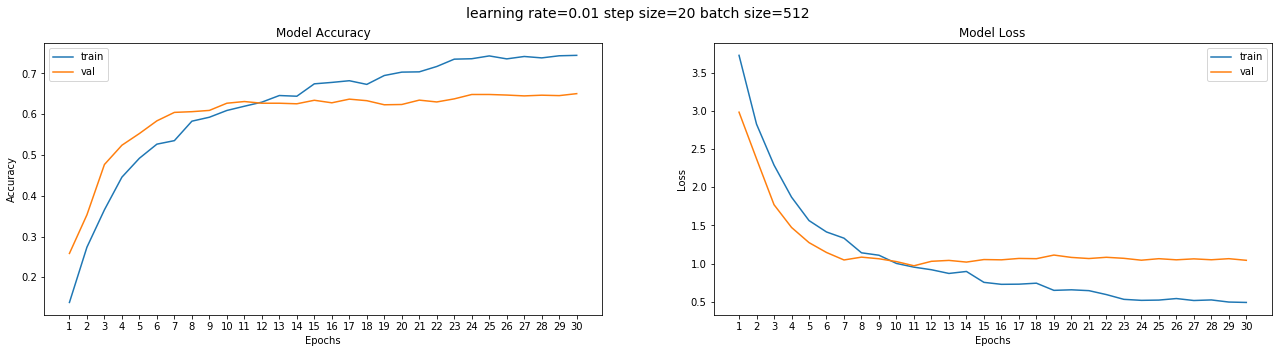

In [0]:
net = train(net, scheduler, optimizer, train_dataloader_da, validation_dataloader_da, train_dataset_size, val_dataset_size, criterion, NUM_EPOCHS, DEVICE)
test(net, test_dataloader_da, DEVICE)

## 5. (Extra) Beyond AlexNet <a name="beyond-alexnet"></a>

**VGG16: Show network architecture**

In [0]:
vgg16()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
summary(vgg16().to(DEVICE), (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

**Define parameters**

In [0]:
lr = 1e-2 # nan with 1e-1
step_size = 20
batch_size = 64
momentum = 0.9

**Prepare dataloaders**

In [0]:
train_dataloader_da = DataLoader(train_dataset_da, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
validation_dataloader_da = DataLoader(validation_dataset_da, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
test_dataloader_da = DataLoader(test_dataset_da, batch_size=batch_size, shuffle=False, num_workers=4)

**Prepare network**

In [0]:
# Use VGG16 this time
net = vgg16(pretrained=True)
# As for Alexnet, the last layer must be adapted
net.classifier[6] = nn.Linear(net.classifier[6].in_features, NUM_CLASSES)

parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=momentum, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=GAMMA)

**Train and test**

Starting epoch 1/30, LR = [0.01]
train Loss: 3.3251 Acc: 0.2839
val Loss: 2.1481 Acc: 0.4946

Starting epoch 2/30, LR = [0.01]
train Loss: 2.9316 Acc: 0.3368
val Loss: 2.1238 Acc: 0.4850

Starting epoch 3/30, LR = [0.01]
train Loss: 2.3144 Acc: 0.4385
val Loss: 1.5091 Acc: 0.6066

Starting epoch 4/30, LR = [0.01]
train Loss: 2.0201 Acc: 0.4952
val Loss: 1.5275 Acc: 0.6039

Starting epoch 5/30, LR = [0.01]
train Loss: 1.9257 Acc: 0.5131
val Loss: 1.3867 Acc: 0.6308

Starting epoch 6/30, LR = [0.01]
train Loss: 1.7334 Acc: 0.5546
val Loss: 1.2274 Acc: 0.6568

Starting epoch 7/30, LR = [0.01]
train Loss: 1.6814 Acc: 0.5692
val Loss: 1.2720 Acc: 0.6557

Starting epoch 8/30, LR = [0.01]
train Loss: 1.5126 Acc: 0.6030
val Loss: 1.1023 Acc: 0.7027

Starting epoch 9/30, LR = [0.01]
train Loss: 1.5215 Acc: 0.6003
val Loss: 1.1746 Acc: 0.6896

Starting epoch 10/30, LR = [0.01]
train Loss: 1.4328 Acc: 0.6117
val Loss: 1.1028 Acc: 0.7128

Starting epoch 11/30, LR = [0.01]
train Loss: 1.2793 Acc: 0

  0%|          | 0/46 [00:00<?, ?it/s]

val Loss: 0.7965 Acc: 0.8012

Training complete in 52m 25s
Best val Acc: 0.802973


100%|██████████| 46/46 [00:47<00:00,  1.29it/s]


Test Accuracy: 0.8257863809194608


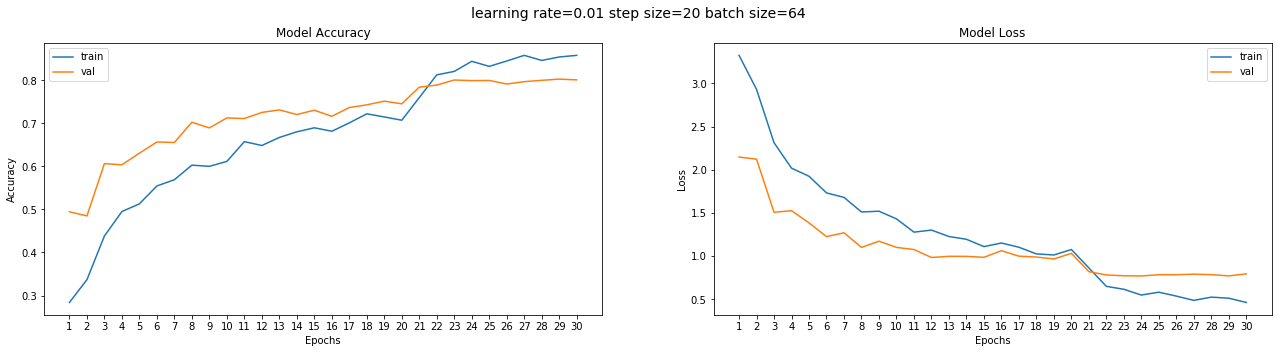

In [0]:
net = train(net, scheduler, optimizer, train_dataloader_da, validation_dataloader_da, train_dataset_size, val_dataset_size, criterion, NUM_EPOCHS, DEVICE)
test(net, test_dataloader_da, DEVICE)